# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-7]
regularization_strengths = [5e4, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for step in range(10):
    print('step', step)
    lr = np.random.uniform(*learning_rates)
    reg = np.random.uniform(*regularization_strengths)
    svm = LinearSVM()
    _ = svm.train(
        X_train_feats, y_train,
        learning_rate=lr, reg=reg,
        num_iters=1500, verbose=True
    )
    y_train_pred = svm.predict(X_train_feats)
    train_acc = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val_feats)
    val_acc = np.mean(y_val == y_val_pred)
    results[(lr, reg)] = (train_acc, val_acc)
    if best_val < val_acc:
        best_val = val_acc
        best_svm = svm


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

step 0
iteration 0 / 1500: loss 2020.644998
iteration 100 / 1500: loss 9.001345
iteration 200 / 1500: loss 8.999986
iteration 300 / 1500: loss 8.999988
iteration 400 / 1500: loss 8.999986
iteration 500 / 1500: loss 8.999989
iteration 600 / 1500: loss 8.999986
iteration 700 / 1500: loss 8.999989
iteration 800 / 1500: loss 8.999989
iteration 900 / 1500: loss 8.999989
iteration 1000 / 1500: loss 8.999985
iteration 1100 / 1500: loss 8.999987
iteration 1200 / 1500: loss 8.999987
iteration 1300 / 1500: loss 8.999986
iteration 1400 / 1500: loss 8.999988
step 1
iteration 0 / 1500: loss 3509.735369
iteration 100 / 1500: loss 8.999993
iteration 200 / 1500: loss 8.999992
iteration 300 / 1500: loss 8.999993
iteration 400 / 1500: loss 8.999994
iteration 500 / 1500: loss 8.999995
iteration 600 / 1500: loss 8.999994
iteration 700 / 1500: loss 8.999992
iteration 800 / 1500: loss 8.999995
iteration 900 / 1500: loss 8.999994
iteration 1000 / 1500: loss 8.999994
iteration 1100 / 1500: loss 8.999993
itera

In [5]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.39


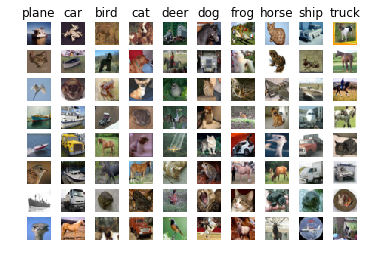

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


Step 0
Learning rate 0.4766668198677182
Hidden size 370
Regularization strength 0.0021975209993
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 1.646091
iteration 200 / 1999: loss 1.500339
iteration 300 / 1999: loss 1.364394
iteration 400 / 1999: loss 1.457778
iteration 500 / 1999: loss 1.335061
iteration 600 / 1999: loss 1.363426
iteration 700 / 1999: loss 1.369437
iteration 800 / 1999: loss 1.346110
iteration 900 / 1999: loss 1.219025
iteration 1000 / 1999: loss 1.383434
iteration 1100 / 1999: loss 1.358538
iteration 1200 / 1999: loss 1.379938
iteration 1300 / 1999: loss 1.220794
iteration 1400 / 1999: loss 1.329410
iteration 1500 / 1999: loss 1.318916
iteration 1600 / 1999: loss 1.245187
iteration 1700 / 1999: loss 1.176899
iteration 1800 / 1999: loss 1.358595
iteration 1900 / 1999: loss 1.297480
Validation accuracy 0.584


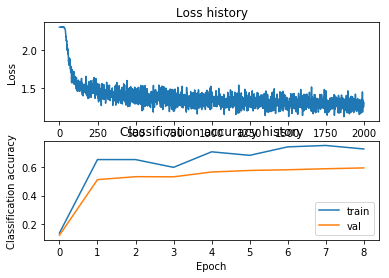

Step 1
Learning rate 0.5433246818681085
Hidden size 487
Regularization strength 0.0020324558408342072
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 1.468690
iteration 200 / 1999: loss 1.520070
iteration 300 / 1999: loss 1.289758
iteration 400 / 1999: loss 1.367241
iteration 500 / 1999: loss 1.275448
iteration 600 / 1999: loss 1.514513
iteration 700 / 1999: loss 1.240527
iteration 800 / 1999: loss 1.371022
iteration 900 / 1999: loss 1.403364
iteration 1000 / 1999: loss 1.283260
iteration 1100 / 1999: loss 1.232404
iteration 1200 / 1999: loss 1.323038
iteration 1300 / 1999: loss 1.326681
iteration 1400 / 1999: loss 1.339869
iteration 1500 / 1999: loss 1.326147
iteration 1600 / 1999: loss 1.240746
iteration 1700 / 1999: loss 1.271634
iteration 1800 / 1999: loss 1.226148
iteration 1900 / 1999: loss 1.205273
Validation accuracy 0.575


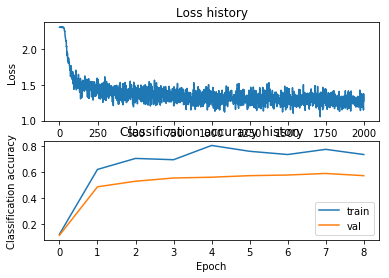

Step 2
Learning rate 0.35441347955345337
Hidden size 417
Regularization strength 0.0076361678280534575
Number of iterations 1999
iteration 0 / 1999: loss 2.302590
iteration 100 / 1999: loss 1.800863
iteration 200 / 1999: loss 1.634146
iteration 300 / 1999: loss 1.652650
iteration 400 / 1999: loss 1.516905
iteration 500 / 1999: loss 1.517328
iteration 600 / 1999: loss 1.589477
iteration 700 / 1999: loss 1.612602
iteration 800 / 1999: loss 1.667556
iteration 900 / 1999: loss 1.547881
iteration 1000 / 1999: loss 1.602798
iteration 1100 / 1999: loss 1.555143
iteration 1200 / 1999: loss 1.486804
iteration 1300 / 1999: loss 1.432837
iteration 1400 / 1999: loss 1.629547
iteration 1500 / 1999: loss 1.475831
iteration 1600 / 1999: loss 1.479511
iteration 1700 / 1999: loss 1.395977
iteration 1800 / 1999: loss 1.411968
iteration 1900 / 1999: loss 1.501805
Validation accuracy 0.528


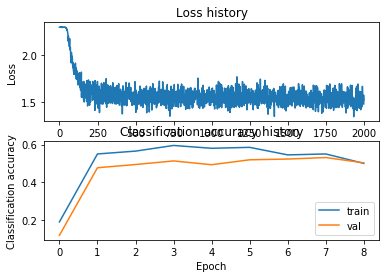

Step 3
Learning rate 0.5555235311577895
Hidden size 350
Regularization strength 0.0003297899008003542
Number of iterations 1999
iteration 0 / 1999: loss 2.302585
iteration 100 / 1999: loss 1.544921
iteration 200 / 1999: loss 1.426473
iteration 300 / 1999: loss 1.312950
iteration 400 / 1999: loss 1.332709
iteration 500 / 1999: loss 1.273090
iteration 600 / 1999: loss 1.222688
iteration 700 / 1999: loss 1.231504
iteration 800 / 1999: loss 1.191992
iteration 900 / 1999: loss 0.972036
iteration 1000 / 1999: loss 0.968172
iteration 1100 / 1999: loss 1.044637
iteration 1200 / 1999: loss 1.016046
iteration 1300 / 1999: loss 1.052178
iteration 1400 / 1999: loss 1.059008
iteration 1500 / 1999: loss 1.019734
iteration 1600 / 1999: loss 0.790096
iteration 1700 / 1999: loss 0.904145
iteration 1800 / 1999: loss 0.998893
iteration 1900 / 1999: loss 0.998027
Validation accuracy 0.566


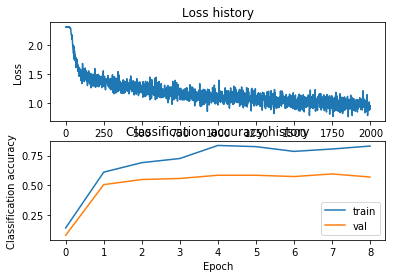

Step 4
Learning rate 0.13863357465546147
Hidden size 479
Regularization strength 0.0025327121153093054
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 2.295630
iteration 200 / 1999: loss 1.908391
iteration 300 / 1999: loss 1.712993
iteration 400 / 1999: loss 1.532999
iteration 500 / 1999: loss 1.397729
iteration 600 / 1999: loss 1.484372
iteration 700 / 1999: loss 1.419319
iteration 800 / 1999: loss 1.379563
iteration 900 / 1999: loss 1.457017
iteration 1000 / 1999: loss 1.419472
iteration 1100 / 1999: loss 1.358185
iteration 1200 / 1999: loss 1.393409
iteration 1300 / 1999: loss 1.322403
iteration 1400 / 1999: loss 1.411968
iteration 1500 / 1999: loss 1.401060
iteration 1600 / 1999: loss 1.291698
iteration 1700 / 1999: loss 1.304079
iteration 1800 / 1999: loss 1.244174
iteration 1900 / 1999: loss 1.361950
Validation accuracy 0.554


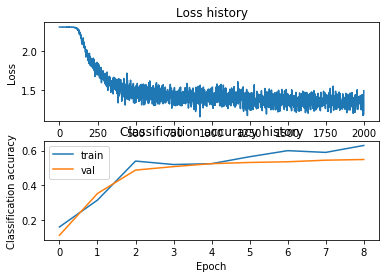

Step 5
Learning rate 0.4954641079867773
Hidden size 345
Regularization strength 0.0020076209527738744
Number of iterations 1999
iteration 0 / 1999: loss 2.302586
iteration 100 / 1999: loss 1.563009
iteration 200 / 1999: loss 1.419446
iteration 300 / 1999: loss 1.500620
iteration 400 / 1999: loss 1.374867
iteration 500 / 1999: loss 1.377116
iteration 600 / 1999: loss 1.351684
iteration 700 / 1999: loss 1.276770
iteration 800 / 1999: loss 1.291672
iteration 900 / 1999: loss 1.182871
iteration 1000 / 1999: loss 1.283708
iteration 1100 / 1999: loss 1.352257
iteration 1200 / 1999: loss 1.411719
iteration 1300 / 1999: loss 1.341108
iteration 1400 / 1999: loss 1.353594
iteration 1500 / 1999: loss 1.152137
iteration 1600 / 1999: loss 1.236335
iteration 1700 / 1999: loss 1.394370
iteration 1800 / 1999: loss 1.226234
iteration 1900 / 1999: loss 1.343571
Validation accuracy 0.564


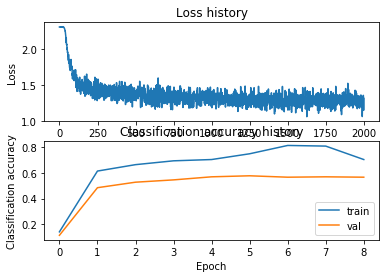

Step 6
Learning rate 0.1364860851974812
Hidden size 479
Regularization strength 0.002088378422319069
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 2.293571
iteration 200 / 1999: loss 1.954139
iteration 300 / 1999: loss 1.648675
iteration 400 / 1999: loss 1.569129
iteration 500 / 1999: loss 1.532045
iteration 600 / 1999: loss 1.462657
iteration 700 / 1999: loss 1.463139
iteration 800 / 1999: loss 1.439409
iteration 900 / 1999: loss 1.374243
iteration 1000 / 1999: loss 1.407571
iteration 1100 / 1999: loss 1.419190
iteration 1200 / 1999: loss 1.396992
iteration 1300 / 1999: loss 1.405839
iteration 1400 / 1999: loss 1.342689
iteration 1500 / 1999: loss 1.303946
iteration 1600 / 1999: loss 1.282429
iteration 1700 / 1999: loss 1.306890
iteration 1800 / 1999: loss 1.361978
iteration 1900 / 1999: loss 1.381369
Validation accuracy 0.553


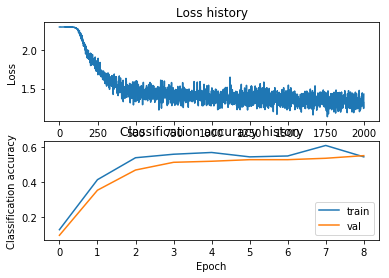

Step 7
Learning rate 0.35793402409408537
Hidden size 364
Regularization strength 0.003968792886875921
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 1.740336
iteration 200 / 1999: loss 1.550467
iteration 300 / 1999: loss 1.514874
iteration 400 / 1999: loss 1.485944
iteration 500 / 1999: loss 1.371915
iteration 600 / 1999: loss 1.332335
iteration 700 / 1999: loss 1.442598
iteration 800 / 1999: loss 1.383626
iteration 900 / 1999: loss 1.554554
iteration 1000 / 1999: loss 1.406118
iteration 1100 / 1999: loss 1.348572
iteration 1200 / 1999: loss 1.239575
iteration 1300 / 1999: loss 1.343635
iteration 1400 / 1999: loss 1.318908
iteration 1500 / 1999: loss 1.374793
iteration 1600 / 1999: loss 1.384246
iteration 1700 / 1999: loss 1.411648
iteration 1800 / 1999: loss 1.289308
iteration 1900 / 1999: loss 1.421444
Validation accuracy 0.563


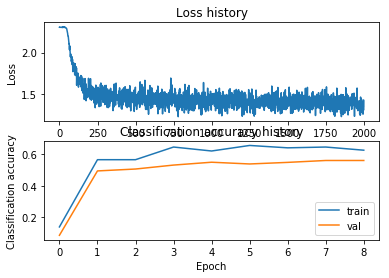

Step 8
Learning rate 0.5909382866768953
Hidden size 327
Regularization strength 0.004287591974309099
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 1.550955
iteration 200 / 1999: loss 1.476881
iteration 300 / 1999: loss 1.489467
iteration 400 / 1999: loss 1.401567
iteration 500 / 1999: loss 1.472484
iteration 600 / 1999: loss 1.445898
iteration 700 / 1999: loss 1.425647
iteration 800 / 1999: loss 1.383189
iteration 900 / 1999: loss 1.365835
iteration 1000 / 1999: loss 1.527885
iteration 1100 / 1999: loss 1.478949
iteration 1200 / 1999: loss 1.434101
iteration 1300 / 1999: loss 1.466129
iteration 1400 / 1999: loss 1.569079
iteration 1500 / 1999: loss 1.456149
iteration 1600 / 1999: loss 1.437737
iteration 1700 / 1999: loss 1.484958
iteration 1800 / 1999: loss 1.393735
iteration 1900 / 1999: loss 1.457613
Validation accuracy 0.544


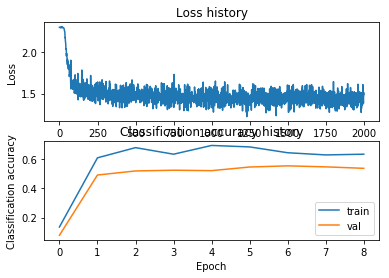

Step 9
Learning rate 0.12697329997843756
Hidden size 389
Regularization strength 0.0009009634161243074
Number of iterations 1999
iteration 0 / 1999: loss 2.302586
iteration 100 / 1999: loss 2.300960
iteration 200 / 1999: loss 1.953203
iteration 300 / 1999: loss 1.635055
iteration 400 / 1999: loss 1.574102
iteration 500 / 1999: loss 1.462980
iteration 600 / 1999: loss 1.386261
iteration 700 / 1999: loss 1.401446
iteration 800 / 1999: loss 1.405072
iteration 900 / 1999: loss 1.419338
iteration 1000 / 1999: loss 1.411564
iteration 1100 / 1999: loss 1.304037
iteration 1200 / 1999: loss 1.354062
iteration 1300 / 1999: loss 1.262754
iteration 1400 / 1999: loss 1.339494
iteration 1500 / 1999: loss 1.295996
iteration 1600 / 1999: loss 1.256018
iteration 1700 / 1999: loss 1.260507
iteration 1800 / 1999: loss 1.234834
iteration 1900 / 1999: loss 1.248704
Validation accuracy 0.554


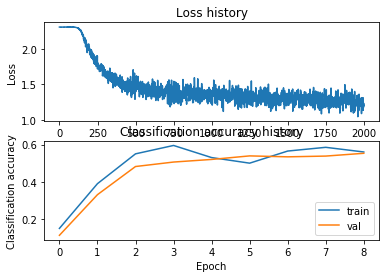

Step 10
Learning rate 0.5193301939544335
Hidden size 317
Regularization strength 0.0014702071975367802
Number of iterations 1999
iteration 0 / 1999: loss 2.302586
iteration 100 / 1999: loss 1.450527
iteration 200 / 1999: loss 1.483939
iteration 300 / 1999: loss 1.554477
iteration 400 / 1999: loss 1.295816
iteration 500 / 1999: loss 1.420432
iteration 600 / 1999: loss 1.323710
iteration 700 / 1999: loss 1.205482
iteration 800 / 1999: loss 1.393363
iteration 900 / 1999: loss 1.198083
iteration 1000 / 1999: loss 1.275540
iteration 1100 / 1999: loss 1.180437
iteration 1200 / 1999: loss 1.161364
iteration 1300 / 1999: loss 1.243633
iteration 1400 / 1999: loss 1.167940
iteration 1500 / 1999: loss 1.119846
iteration 1600 / 1999: loss 1.268512
iteration 1700 / 1999: loss 1.096101
iteration 1800 / 1999: loss 1.100303
iteration 1900 / 1999: loss 1.227867
Validation accuracy 0.572


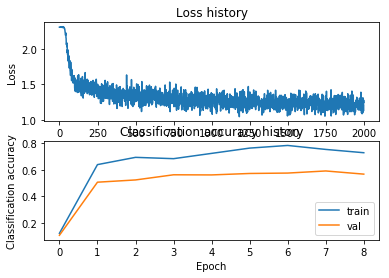

Step 11
Learning rate 0.5094257399057052
Hidden size 431
Regularization strength 0.0034381950212108237
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 1.649247
iteration 200 / 1999: loss 1.446580
iteration 300 / 1999: loss 1.416282
iteration 400 / 1999: loss 1.422790
iteration 500 / 1999: loss 1.488023
iteration 600 / 1999: loss 1.446430
iteration 700 / 1999: loss 1.471311
iteration 800 / 1999: loss 1.405333
iteration 900 / 1999: loss 1.497519
iteration 1000 / 1999: loss 1.386317
iteration 1100 / 1999: loss 1.421690
iteration 1200 / 1999: loss 1.392853
iteration 1300 / 1999: loss 1.473729
iteration 1400 / 1999: loss 1.378323
iteration 1500 / 1999: loss 1.392020
iteration 1600 / 1999: loss 1.261610
iteration 1700 / 1999: loss 1.438459
iteration 1800 / 1999: loss 1.426486
iteration 1900 / 1999: loss 1.466884
Validation accuracy 0.574


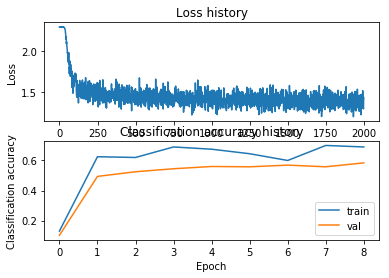

Step 12
Learning rate 0.15164602964764165
Hidden size 309
Regularization strength 0.005607163728037037
Number of iterations 1999
iteration 0 / 1999: loss 2.302588
iteration 100 / 1999: loss 2.297810
iteration 200 / 1999: loss 1.892427
iteration 300 / 1999: loss 1.640316
iteration 400 / 1999: loss 1.503263
iteration 500 / 1999: loss 1.554568
iteration 600 / 1999: loss 1.468626
iteration 700 / 1999: loss 1.506694
iteration 800 / 1999: loss 1.482610
iteration 900 / 1999: loss 1.582054
iteration 1000 / 1999: loss 1.414569
iteration 1100 / 1999: loss 1.527910
iteration 1200 / 1999: loss 1.501558
iteration 1300 / 1999: loss 1.606849
iteration 1400 / 1999: loss 1.473074
iteration 1500 / 1999: loss 1.473264
iteration 1600 / 1999: loss 1.488063
iteration 1700 / 1999: loss 1.388950
iteration 1800 / 1999: loss 1.460265
iteration 1900 / 1999: loss 1.394091
Validation accuracy 0.524


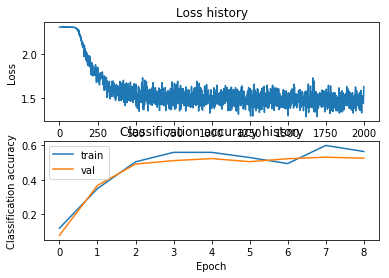

Step 13
Learning rate 0.2565666437959431
Hidden size 456
Regularization strength 0.005919651748134327
Number of iterations 1999
iteration 0 / 1999: loss 2.302590
iteration 100 / 1999: loss 2.023676
iteration 200 / 1999: loss 1.535003
iteration 300 / 1999: loss 1.580809
iteration 400 / 1999: loss 1.348862
iteration 500 / 1999: loss 1.481355
iteration 600 / 1999: loss 1.540180
iteration 700 / 1999: loss 1.483521
iteration 800 / 1999: loss 1.481706
iteration 900 / 1999: loss 1.480605
iteration 1000 / 1999: loss 1.485361
iteration 1100 / 1999: loss 1.440053
iteration 1200 / 1999: loss 1.490808
iteration 1300 / 1999: loss 1.426215
iteration 1400 / 1999: loss 1.522762
iteration 1500 / 1999: loss 1.487469
iteration 1600 / 1999: loss 1.458456
iteration 1700 / 1999: loss 1.551169
iteration 1800 / 1999: loss 1.399029
iteration 1900 / 1999: loss 1.602563
Validation accuracy 0.532


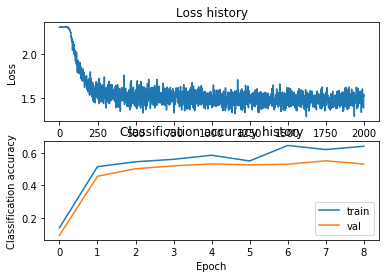

Step 14
Learning rate 0.34135507638670914
Hidden size 402
Regularization strength 0.007594238533038213
Number of iterations 1999
iteration 0 / 1999: loss 2.302590
iteration 100 / 1999: loss 1.840734
iteration 200 / 1999: loss 1.603942
iteration 300 / 1999: loss 1.570689
iteration 400 / 1999: loss 1.563261
iteration 500 / 1999: loss 1.487542
iteration 600 / 1999: loss 1.579374
iteration 700 / 1999: loss 1.468060
iteration 800 / 1999: loss 1.585505
iteration 900 / 1999: loss 1.526283
iteration 1000 / 1999: loss 1.617396
iteration 1100 / 1999: loss 1.641750
iteration 1200 / 1999: loss 1.642656
iteration 1300 / 1999: loss 1.466795
iteration 1400 / 1999: loss 1.484429
iteration 1500 / 1999: loss 1.516462
iteration 1600 / 1999: loss 1.590179
iteration 1700 / 1999: loss 1.452159
iteration 1800 / 1999: loss 1.588910
iteration 1900 / 1999: loss 1.432753
Validation accuracy 0.53


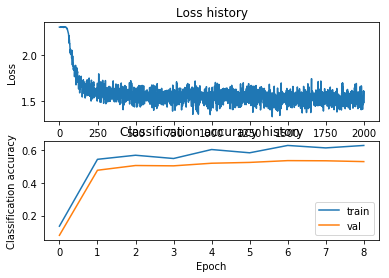

Step 15
Learning rate 0.12565235222499685
Hidden size 365
Regularization strength 0.0032216507378033097
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 2.303024
iteration 200 / 1999: loss 1.984819
iteration 300 / 1999: loss 1.677321
iteration 400 / 1999: loss 1.482114
iteration 500 / 1999: loss 1.540208
iteration 600 / 1999: loss 1.355816
iteration 700 / 1999: loss 1.527939
iteration 800 / 1999: loss 1.473560
iteration 900 / 1999: loss 1.421171
iteration 1000 / 1999: loss 1.383678
iteration 1100 / 1999: loss 1.578966
iteration 1200 / 1999: loss 1.453148
iteration 1300 / 1999: loss 1.488947
iteration 1400 / 1999: loss 1.487287
iteration 1500 / 1999: loss 1.477083
iteration 1600 / 1999: loss 1.343172
iteration 1700 / 1999: loss 1.447323
iteration 1800 / 1999: loss 1.333767
iteration 1900 / 1999: loss 1.309237
Validation accuracy 0.539


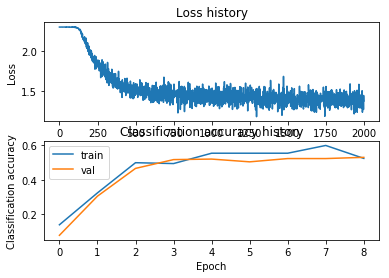

Step 16
Learning rate 0.407101682625965
Hidden size 452
Regularization strength 0.0071388566563279805
Number of iterations 1999
iteration 0 / 1999: loss 2.302590
iteration 100 / 1999: loss 1.718965
iteration 200 / 1999: loss 1.668226
iteration 300 / 1999: loss 1.506270
iteration 400 / 1999: loss 1.567901
iteration 500 / 1999: loss 1.628454
iteration 600 / 1999: loss 1.487281
iteration 700 / 1999: loss 1.533551
iteration 800 / 1999: loss 1.568904
iteration 900 / 1999: loss 1.519335
iteration 1000 / 1999: loss 1.489634
iteration 1100 / 1999: loss 1.481885
iteration 1200 / 1999: loss 1.472204
iteration 1300 / 1999: loss 1.556338
iteration 1400 / 1999: loss 1.484967
iteration 1500 / 1999: loss 1.559401
iteration 1600 / 1999: loss 1.516104
iteration 1700 / 1999: loss 1.474040
iteration 1800 / 1999: loss 1.597422
iteration 1900 / 1999: loss 1.507906
Validation accuracy 0.526


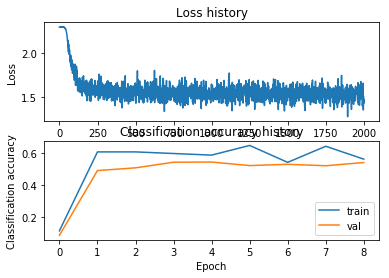

Step 17
Learning rate 0.593975039820337
Hidden size 499
Regularization strength 0.007061116897225807
Number of iterations 1999
iteration 0 / 1999: loss 2.302591
iteration 100 / 1999: loss 1.565352
iteration 200 / 1999: loss 1.628801
iteration 300 / 1999: loss 1.554926
iteration 400 / 1999: loss 1.558747
iteration 500 / 1999: loss 1.424901
iteration 600 / 1999: loss 1.584690
iteration 700 / 1999: loss 1.644328
iteration 800 / 1999: loss 1.579369
iteration 900 / 1999: loss 1.552349
iteration 1000 / 1999: loss 1.603979
iteration 1100 / 1999: loss 1.531365
iteration 1200 / 1999: loss 1.587391
iteration 1300 / 1999: loss 1.564591
iteration 1400 / 1999: loss 1.506960
iteration 1500 / 1999: loss 1.393802
iteration 1600 / 1999: loss 1.501148
iteration 1700 / 1999: loss 1.478774
iteration 1800 / 1999: loss 1.526701
iteration 1900 / 1999: loss 1.619526
Validation accuracy 0.514


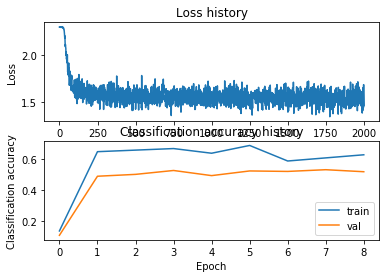

Step 18
Learning rate 0.32853701830560467
Hidden size 357
Regularization strength 0.0021854623759671055
Number of iterations 1999
iteration 0 / 1999: loss 2.302586
iteration 100 / 1999: loss 1.787362
iteration 200 / 1999: loss 1.544379
iteration 300 / 1999: loss 1.340368
iteration 400 / 1999: loss 1.257663
iteration 500 / 1999: loss 1.305154
iteration 600 / 1999: loss 1.399348
iteration 700 / 1999: loss 1.338992
iteration 800 / 1999: loss 1.320058
iteration 900 / 1999: loss 1.463770
iteration 1000 / 1999: loss 1.238228
iteration 1100 / 1999: loss 1.352016
iteration 1200 / 1999: loss 1.334392
iteration 1300 / 1999: loss 1.300831
iteration 1400 / 1999: loss 1.263499
iteration 1500 / 1999: loss 1.261555
iteration 1600 / 1999: loss 1.283082
iteration 1700 / 1999: loss 1.342998
iteration 1800 / 1999: loss 1.330154
iteration 1900 / 1999: loss 1.254939
Validation accuracy 0.598


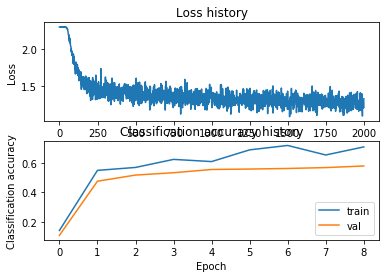

Step 19
Learning rate 0.5507135638242697
Hidden size 451
Regularization strength 0.0015367322342824963
Number of iterations 1999
iteration 0 / 1999: loss 2.302586
iteration 100 / 1999: loss 1.574087
iteration 200 / 1999: loss 1.393761
iteration 300 / 1999: loss 1.429413
iteration 400 / 1999: loss 1.373980
iteration 500 / 1999: loss 1.383255
iteration 600 / 1999: loss 1.304561
iteration 700 / 1999: loss 1.277240
iteration 800 / 1999: loss 1.377727
iteration 900 / 1999: loss 1.251147
iteration 1000 / 1999: loss 1.296164
iteration 1100 / 1999: loss 1.346742
iteration 1200 / 1999: loss 1.129189
iteration 1300 / 1999: loss 1.249575
iteration 1400 / 1999: loss 1.205939
iteration 1500 / 1999: loss 1.358034
iteration 1600 / 1999: loss 1.160301
iteration 1700 / 1999: loss 1.203536
iteration 1800 / 1999: loss 1.127394
iteration 1900 / 1999: loss 1.197824
Validation accuracy 0.585


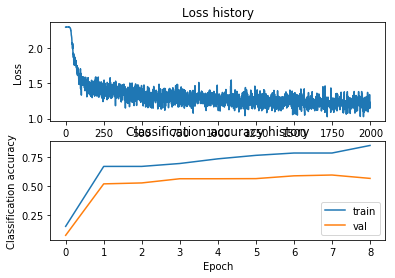

Step 20
Learning rate 0.4378535223811828
Hidden size 448
Regularization strength 0.0027023742556902004
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 1.625360
iteration 200 / 1999: loss 1.560844
iteration 300 / 1999: loss 1.429644
iteration 400 / 1999: loss 1.490069
iteration 500 / 1999: loss 1.383031
iteration 600 / 1999: loss 1.385089
iteration 700 / 1999: loss 1.433477
iteration 800 / 1999: loss 1.418252
iteration 900 / 1999: loss 1.407105
iteration 1000 / 1999: loss 1.394546
iteration 1100 / 1999: loss 1.270249
iteration 1200 / 1999: loss 1.377986
iteration 1300 / 1999: loss 1.358840
iteration 1400 / 1999: loss 1.337454
iteration 1500 / 1999: loss 1.229540
iteration 1600 / 1999: loss 1.225379
iteration 1700 / 1999: loss 1.286695
iteration 1800 / 1999: loss 1.412410
iteration 1900 / 1999: loss 1.238704
Validation accuracy 0.555


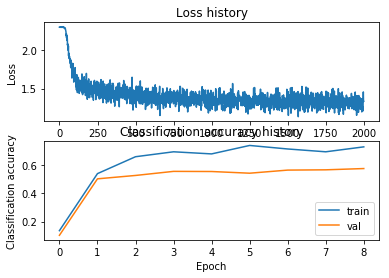

Step 21
Learning rate 0.5271201075587063
Hidden size 461
Regularization strength 0.002474016691445842
Number of iterations 1999
iteration 0 / 1999: loss 2.302587
iteration 100 / 1999: loss 1.462913
iteration 200 / 1999: loss 1.266127
iteration 300 / 1999: loss 1.490784
iteration 400 / 1999: loss 1.487811
iteration 500 / 1999: loss 1.456011
iteration 600 / 1999: loss 1.417763
iteration 700 / 1999: loss 1.384973
iteration 800 / 1999: loss 1.371717
iteration 900 / 1999: loss 1.357470
iteration 1000 / 1999: loss 1.374803
iteration 1100 / 1999: loss 1.259139
iteration 1200 / 1999: loss 1.428446
iteration 1300 / 1999: loss 1.294915
iteration 1400 / 1999: loss 1.280183
iteration 1500 / 1999: loss 1.268910
iteration 1600 / 1999: loss 1.371561
iteration 1700 / 1999: loss 1.313645
iteration 1800 / 1999: loss 1.183500
iteration 1900 / 1999: loss 1.250707
Validation accuracy 0.585


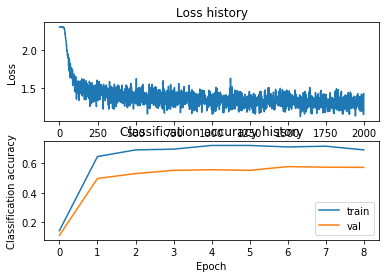

Step 22
Learning rate 0.33266357441733885
Hidden size 337
Regularization strength 0.001865748560640589
Number of iterations 1999
iteration 0 / 1999: loss 2.302586
iteration 100 / 1999: loss 1.781208
iteration 200 / 1999: loss 1.495374
iteration 300 / 1999: loss 1.375996
iteration 400 / 1999: loss 1.442699
iteration 500 / 1999: loss 1.500700
iteration 600 / 1999: loss 1.419126
iteration 700 / 1999: loss 1.312556
iteration 800 / 1999: loss 1.403675
iteration 900 / 1999: loss 1.341410
iteration 1000 / 1999: loss 1.288718
iteration 1100 / 1999: loss 1.451135
iteration 1200 / 1999: loss 1.253957
iteration 1300 / 1999: loss 1.346181
iteration 1400 / 1999: loss 1.197089
iteration 1500 / 1999: loss 1.351044
iteration 1600 / 1999: loss 1.296016
iteration 1700 / 1999: loss 1.254810
iteration 1800 / 1999: loss 1.223135
iteration 1900 / 1999: loss 1.186175
Validation accuracy 0.588


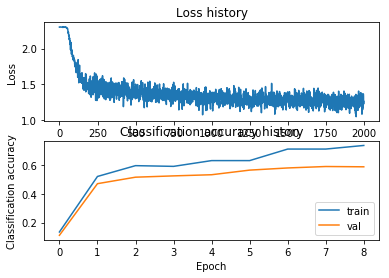

Step 23
Learning rate 0.5597872585965245
Hidden size 414
Regularization strength 0.005895958906149678
Number of iterations 1999
iteration 0 / 1999: loss 2.302589
iteration 100 / 1999: loss 1.660823
iteration 200 / 1999: loss 1.596685
iteration 300 / 1999: loss 1.508017
iteration 400 / 1999: loss 1.613884
iteration 500 / 1999: loss 1.523282
iteration 600 / 1999: loss 1.510335
iteration 700 / 1999: loss 1.504112
iteration 800 / 1999: loss 1.594925
iteration 900 / 1999: loss 1.564678
iteration 1000 / 1999: loss 1.410959
iteration 1100 / 1999: loss 1.424406
iteration 1200 / 1999: loss 1.461844
iteration 1300 / 1999: loss 1.553290
iteration 1400 / 1999: loss 1.459963
iteration 1500 / 1999: loss 1.499481
iteration 1600 / 1999: loss 1.537902
iteration 1700 / 1999: loss 1.431739
iteration 1800 / 1999: loss 1.515194
iteration 1900 / 1999: loss 1.513005
Validation accuracy 0.544


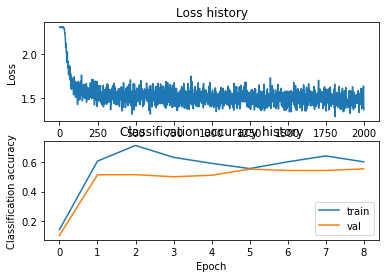

Step 24
Learning rate 0.5167214037545276
Hidden size 404
Regularization strength 0.00040744470413499735
Number of iterations 1999
iteration 0 / 1999: loss 2.302586
iteration 100 / 1999: loss 1.505258
iteration 200 / 1999: loss 1.297761
iteration 300 / 1999: loss 1.285960
iteration 400 / 1999: loss 1.272666
iteration 500 / 1999: loss 1.233966
iteration 600 / 1999: loss 1.417703
iteration 700 / 1999: loss 1.178205
iteration 800 / 1999: loss 1.091554
iteration 900 / 1999: loss 1.121223
iteration 1000 / 1999: loss 1.108462
iteration 1100 / 1999: loss 1.128127
iteration 1200 / 1999: loss 1.232425
iteration 1300 / 1999: loss 1.113203
iteration 1400 / 1999: loss 1.189655
iteration 1500 / 1999: loss 1.152227
iteration 1600 / 1999: loss 1.045666
iteration 1700 / 1999: loss 1.028365
iteration 1800 / 1999: loss 0.902837
iteration 1900 / 1999: loss 0.933864
Validation accuracy 0.589


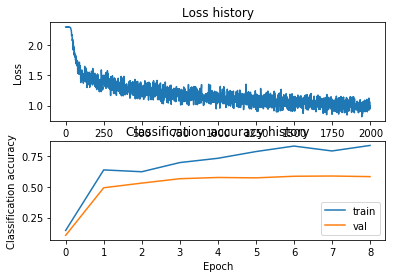

In [29]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def make_plot(stats):
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()


best_val_acc = 0

n_tune_steps = 25
learning_rate_range = [3e-1, 6e-1]
hidden_size_range = [330, 500]
regularization_range = [0.0, 0.003]
num_iters_range = [1999, 2000]
result = []

for step in range(n_tune_steps):
    print('Step', step)
    lr = np.random.uniform(*learning_rate_range)
    hs = np.random.randint(*hidden_size_range)
    reg = np.random.uniform(*regularization_range)
    num_iters = np.random.randint(*num_iters_range)
    print('Learning rate', lr)
    print('Hidden size', hs)
    print('Regularization strength', reg)
    print('Number of iterations', num_iters)

    net = TwoLayerNet(input_dim, hs, num_classes)

    stats = net.train(
        X_train_feats, y_train, X_val_feats, y_val,
        num_iters=num_iters, batch_size=200,
        learning_rate=lr, learning_rate_decay=0.95,
        reg=reg, verbose=True
    )

    y_val_pred = net.predict(X_val_feats)
    val_acc = np.mean(y_val == y_val_pred)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_net = net

    print('Validation accuracy', val_acc)

    make_plot(stats)

    result.append(
        dict(
            learning_rate=lr,
            hidden_size=hs,
            regularization_strength=reg,
            num_iters=num_iters,
            val_acc=val_acc,
            stats=stats
        )
    )
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [30]:
result.sort(key=lambda d: d['val_acc'], reverse=True)

print('Best 7 results')
for d in result[:7]:
    print(
        'lr:', d['learning_rate'],
        'hs:', d['hidden_size'],
        'reg:', d['regularization_strength'],
        'num_iters:', d['num_iters'],
        'val_acc:', d['val_acc']
    )

Best 7 results
lr: 0.32853701830560467 hs: 357 reg: 0.0021854623759671055 num_iters: 1999 val_acc: 0.598
lr: 0.5167214037545276 hs: 404 reg: 0.00040744470413499735 num_iters: 1999 val_acc: 0.589
lr: 0.33266357441733885 hs: 337 reg: 0.001865748560640589 num_iters: 1999 val_acc: 0.588
lr: 0.5507135638242697 hs: 451 reg: 0.0015367322342824963 num_iters: 1999 val_acc: 0.585
lr: 0.5271201075587063 hs: 461 reg: 0.002474016691445842 num_iters: 1999 val_acc: 0.585
lr: 0.4766668198677182 hs: 370 reg: 0.0021975209993 num_iters: 1999 val_acc: 0.584
lr: 0.5433246818681085 hs: 487 reg: 0.0020324558408342072 num_iters: 1999 val_acc: 0.575


In [31]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.567
